## **About Dataset**
Data source: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction/data?select=Clean_Dataset.csv

Dataset contains information about flight booking options from the website Easemytrip for flight travel between India's top 6 metro cities. There are 300261 datapoints and 11 features in the cleaned dataset. This dataset is a modified result that combines the files 'economy.csv' and 'business.csv' available on the website page. The modification includes the addition of columns for date and holidays.

Description:
* `Date`: The date when tickets are available
* `Airline:` The name of the airline company is stored in the airline column. It is a categorical feature having 8 different airlines.
* `Flight:` Flight stores information regarding the plane's flight code. It is a categorical feature.
* `Source City:` City from which the flight takes off. It is a categorical feature having 6 unique cities.
* `Departure Time:` This is a derived categorical feature obtained created by grouping time periods into bins. It stores information about the departure time and have 6 unique time labels.
* `Stop:` A categorical feature with 3 distinct values that stores the number of stops between the source and destination cities.
* `Arrival Time:` This is a derived categorical feature created by grouping time intervals into bins. It has six distinct time labels and keeps information about the arrival time.
* `Destination City:` City where the flight will land. It is a categorical feature having 6 unique cities.
* `Class:` A categorical feature that contains information on seat class; it has two distinct values: Business and Economy.
* `Duration:` A continuous feature that displays the overall amount of time it takes to travel between cities in hours.
* `Days Left:` This is a derived characteristic that is calculated by subtracting the trip date by the booking date.
* `Price:` Target variable stores information of the ticket price.

## **Required Libraries**

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from scipy.stats import zscore, spearmanr, pearsonr
from scipy import stats
from jcopml.tuning import grid_search_params as gsp, random_search_params as rsp

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
import warnings
warnings.filterwarnings("ignore")
plt.style.use('bmh')
sns.set_style("whitegrid")

In [3]:
# Models Library
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso #gud
from sklearn.linear_model import Lars
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet #gud
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.svm import SVR
from sklearn.svm import NuSVR #gud
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.cross_decomposition import PLSRegression
# ==========  Non-Linear Regressor  ==========================
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

## **Import The Data**

In [4]:
data = pd.read_csv("Clean_Dataset.csv")
print('Data shape:', data.shape)
data.head()

Data shape: (300153, 12)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [6]:
# Check for missing values
data.isna().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [11]:
# Check for duplicates
print('Number of duplicates: ', data.duplicated().sum())

Number of duplicates:  0


## **Feature Engineering**
* Unimportant columns will be removed.
* Outliers will be handled by removal.
* Airline, Cities, Time will be encoded to matrices columns.
* Stops will be encoded to ordinal values.
* Class will be encoded to binary values.

In [12]:
df = data.copy()

In [13]:
# Drop unimportant columns
df = data.copy()
df.drop(['Unnamed: 0', 'flight'], axis=1, inplace=True)
df.head()

,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [14]:
# Define continuous and categorical columns
continuous_cols = [cols for cols in df.columns if df[cols].dtype != 'O']
categorical_cols = [cols for cols in df.columns if df[cols].dtype == 'O']
print('Continuous columns: ', continuous_cols)
print('Categorical columns: ', categorical_cols)

Continuous columns:  ['duration', 'days_left', 'price']
Categorical columns:  ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']


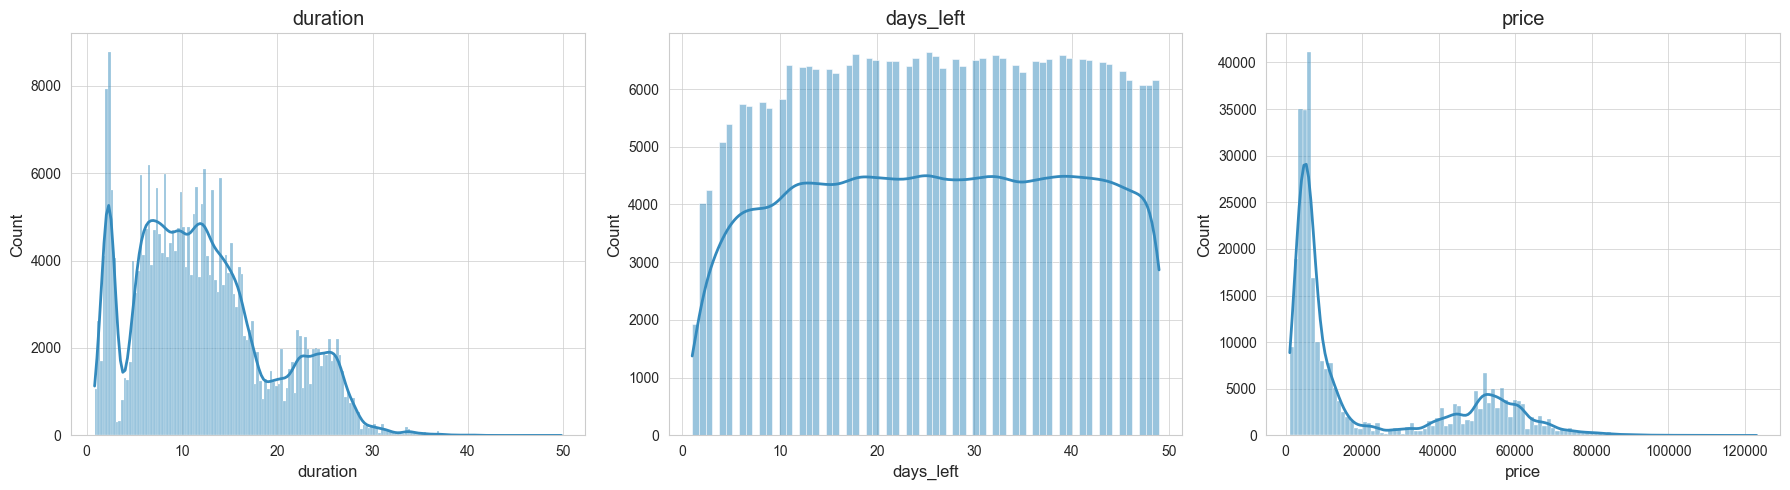

In [15]:
# Data Distribution for Continuous Columns
n_cols = 3
n_rows = (len(continuous_cols) + 2) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))

for i, col in enumerate(continuous_cols):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,300153.0,12.221021,7.191997,0.83,6.83,11.25,16.17,49.83
days_left,300153.0,26.004751,13.561004,1.00,15.00,26.00,38.00,49.00
price,300153.0,20889.660523,22697.767366,1105.00,4783.00,7425.00,42521.00,123071.00


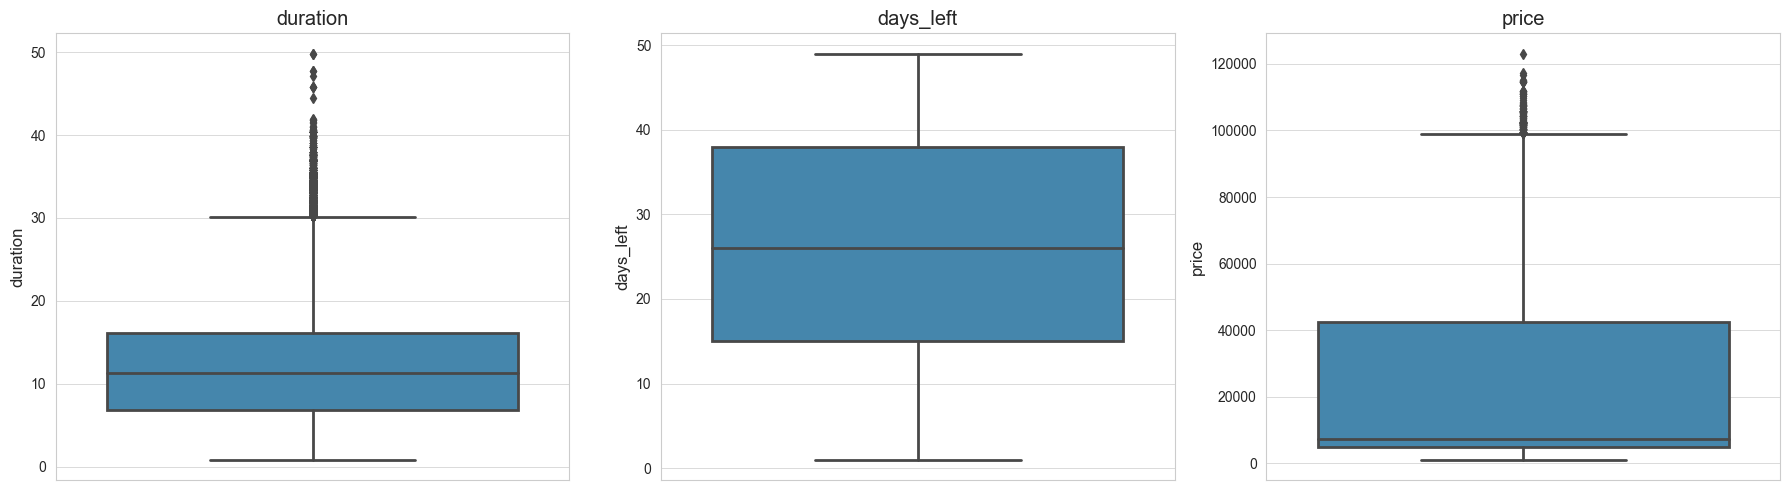

In [17]:
# Detecting outliers
num_cols = len(continuous_cols)
num_rows = (num_cols // 3) + (1 if num_cols % 3 else 0)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

for i, feature in enumerate(continuous_cols):
    ax = axs.flatten()[i]
    sns.boxplot(y=df[feature], ax=ax)
    ax.set_title(feature)
    
# Remove empty subplots if the number of columns is not a multiple of 3
for j in range(i + 1, len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

### **Handling Outliers**

In [19]:
# Checking if it saves to remove outliers on price
min_business_price = df[df['class'] == 'Business']['price'].min()
print(f"The minimum price for business class is: {min_business_price}")

The minimum price for business class is: 12000


**Removing Outliers on Price**

In [20]:
# Define Quartiles
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removing outliers
print('Outlier shape:', df[(df['price'] < lower_bound) | (df['price'] > upper_bound)].shape)
print('Data shape:', df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].shape)
df_clean = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]
df_clean.head()

Outlier shape: (123, 10)
Data shape: (300030, 10)


,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


**Removing Outliers on Duration**

In [21]:
# Define Quartiles
Q1 = df_clean['duration'].quantile(0.25)
Q3 = df_clean['duration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removing outliers
print('Outlier shape:', df_clean[(df_clean['duration'] < lower_bound) | (df_clean['duration'] > upper_bound)].shape)
print('Data shape:', df_clean[(df_clean['duration'] >= lower_bound) & (df_clean['duration'] <= upper_bound)].shape)
df_clean = df_clean[(df_clean['duration'] >= lower_bound) & (df_clean['duration'] <= upper_bound)]
df_clean.head()

Outlier shape: (2110, 10)
Data shape: (297920, 10)


,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


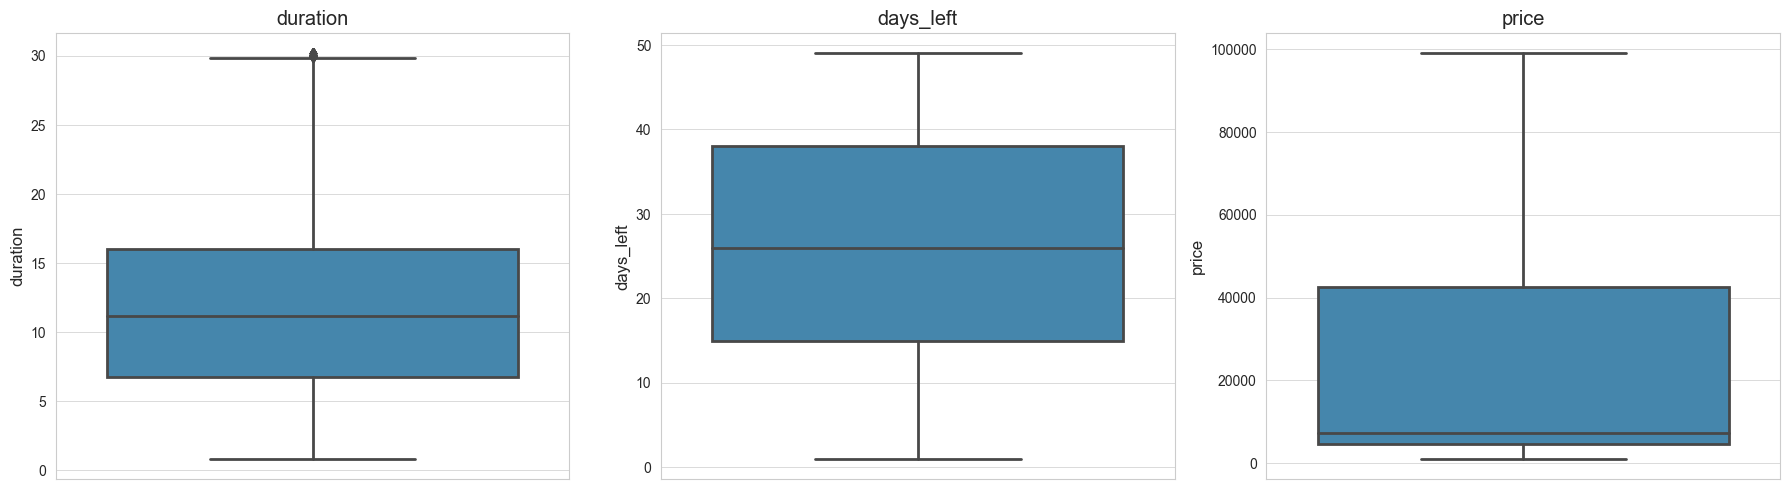

In [22]:
num_cols = len(continuous_cols)
num_rows = (num_cols // 3) + (1 if num_cols % 3 else 0)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))

for i, feature in enumerate(continuous_cols):
    ax = axs.flatten()[i]
    sns.boxplot(y=df_clean[feature], ax=ax)
    ax.set_title(feature)
    
# Remove empty subplots if the number of columns is not a multiple of 3
for j in range(i + 1, len(axs.flatten())):
    fig.delaxes(axs.flatten()[j])

plt.tight_layout()
plt.show()

In [23]:
df_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,297920.0,12.071699,6.994057,0.83,6.75,11.17,16.0,30.17
days_left,297920.0,26.039370,13.549647,1.00,15.00,26.00,38.0,49.00
price,297920.0,20882.941276,22672.112441,1105.00,4757.00,7424.00,42521.0,98972.00


### **Transformation**

In [197]:
def transform_it_man(data):
    ohe_columns = ['airline', 'source_city', 'destination_city', 'departure_time', 'arrival_time']
    data = pd.get_dummies(data, columns=ohe_columns, prefix=ohe_columns, dtype='float64')

    # Applying binary encoding
    class_mapping = {'Economy': 0, 'Business': 1}
    data['class'] = data['class'].astype(str).map(class_mapping)

    # Applying ordinal encoding
    desired_order = ['zero', 'one', 'two_or_more']
    oe = OrdinalEncoder(categories=[desired_order])
    data['stops'] = oe.fit_transform(data[['stops']])
    
    return data

In [198]:
# Applying Transformation
df_clean = transform_it_man(df_clean)
print('Duplicates:', df_clean[df_clean.duplicated()].shape)
df_clean = df_clean[~df_clean.duplicated()]
df_clean = df_clean.reset_index()
print('Data shape:', df_clean.shape)
df_clean.tail()

Duplicates: (2213, 35)
Data shape: (295707, 36)


,index,stops,class,duration,days_left,price,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,...,departure_time_Evening,departure_time_Late_Night,departure_time_Morning,departure_time_Night,arrival_time_Afternoon,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night
295702,300148,1.0,1,10.08,49,69265,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
295703,300149,1.0,1,10.42,49,77105,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
295704,300150,1.0,1,13.83,49,79099,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
295705,300151,1.0,1,10.00,49,81585,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
295706,300152,1.0,1,10.08,49,81585,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [199]:
# # Save the cleaned dataset
# df_clean.to_csv('Dataset_Outliers_Cleaned.csv', index=False)